<a href="https://colab.research.google.com/github/dan-a-iancu/airm/blob/master/Gurobi_Python_Tutorial/Oro_Verde_tutorial_with_videos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a id="intro"></a>
## Solving the "Oro Verde" Problem and Expanded Tutorial on Linear Optimization 
The goal of this Jupyter notebook is to complement the [Handout on Linear Optimization](https://canvas.stanford.edu/courses/90540/files/3520978/download?wrap=1), available as a PDF file on the course Canvas site. If you are not familiar with this handout, we suggest reading the first two sections of the PDF document, and then returning here. We have two related goals here:
 1. To show you how to solve the Oro Verde tree planting problem using Python and Gurobi;
 2. To provide several hints for how to construct good models in practice.

As such, this notebook is intended as a broader tutorial that includes several useful functions for doing linear optimization in Python and Gurobi, and you may find it to be a useful reference for several future problems.
___

The notebook is organized in several different sections. Here is a quick outline including the main functions of interest, to make it easy in case you want to jump to a particular section:
 - [Section 1](#params_data) : import data using __pandas__. [ ``pandas.read_excel(...)`` ]
 - [Section 2](#create_model) : create an empty __Model__ in Gurobi. [ ``gurobi.Model(...)`` ]
 - [Section 3](#decisions) : create and add decision variables in the Gurobi model. [ ``Model.addVar(...), Model.addVars(...), gurobi.quicksum()`` ]
 - [Section 4](#objective) : formulate and add an objective in the Gurobi model. [ ``Model.setObjective(...)`` ] 
 - [Section 5](#constraints) : formulate and add constraints to the Gurobi model. [ ``Model.addConstr(...)`` ]
 - [Section 6](#inspecting_model) : inspect the Gurobi model; [update it](#model_update) and [write it](#write_model) to a file. [ ``Model.update(), Model.write(...)`` ]
 - [Section 7](#solve) : solving/optimizing the Gurobi model. [ ``Model.optimize()`` ]
 - [Section 8](#printing) : extracting the results of the optimization. [ ``DecisionVariable.X , Model.objVal`` ] 
 - [Section 9](#evaluating_constraints) : extracting information about constraints [ ``Model.getConstrs(), Constraint.ConstrName, Constraint.RHS, Constraint.Sense, Constraint.Slack``]
 - [Section 10](#Gurobi_messages) : output messages in Gurobi reporting a model is [solved to optimality](#solved_optimality), [infeasibile](#infeasible) or [unbounded](#unbounded)
 - [Section 11](#change_model) : sensitivity analysis and shadow prices; changing the model and re-solving repeatedly [ ``Model.getConstrByName(), Constraint.Pi``]
 
Lastly, a small note on the color coding used in our Markdown cells in this notebook. We will tend to use <font color=red>red fonts for things that are critical</font>, meaning these are things you __have to understand__ to build a model. We will also use <font color=blue>blue font for things that relate to "good practice,"</font> meaning they can __make your life easier if you want to get better at building (real-world) models__. All the other things are just plain-interesting and worth reading. :-)

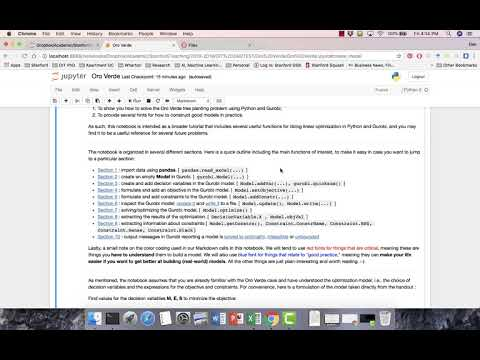

In [1]:
# import a function that allows embedding YouTube videos inside the Jupyter Notebook
from IPython.display import YouTubeVideo

# import the introductory video
YouTubeVideo(id='_b5bFTCg9Js',width=600,height=300)

_______
<a id="basic_model"></a>
As mentioned, the notebook assumes that you are already familiar with the Oro Verde case and have understood the optimization model, i.e., the choice of decision variables and the expressions for the objective and constraints. For convenience, here is a formulation of the model taken from the handout :

Find values for the decision variables __M, E, S__ to minimize the objective:        <br>

>  5.40 · __M__ + 3.20 · __E__ + 4.50 · __S__ <br>

Subject to the constraints: <br>
>    (1): 130 · __M__ + 3, 600 · __E__ + 400 · __S__ ≤ 150, 000 <br>
>    (2): 76 · __M__ + 48 · __E__ + 34 · __S__ ≤ 50, 000  <br>
>    (3): __M__ ≤ 1,000  <br>
>    (4): __E__ ≤ 500 <br>
>    (5): __S__ ≤ 1,500  <br>
>    (6): __E__ ≥ 15  <br>
>    (7): 0.70 · 4.3 · __M__ + 0.60 · 3.7 · __E__ + 0.80 · 2.80 · __S__ ≥ 1, 800  <br>
>    (8): __M__ ≥ 0, __E__ ≥ 0, and __S__ ≥ 0. <br>

_______

In [2]:
# import the video about modules
#YouTubeVideo(id='_b5bFTCg9Js',width=600,height=300)

#### First step in any file that builds an optimization model using Gurobi is to include the Gurobi package. In **Colab**, we first install Gurobi and then import the entire module.

In [3]:
# install Gurobi (our linear optimization solver)
!pip install -i https://pypi.gurobi.com gurobipy
from gurobipy import *

Looking in indexes: https://pypi.gurobi.com


You can also import any other modules that you might need. We will use the _pandas_ module to read in data from larger files, so we import it here.

In [4]:
import pandas as pd

________
<a id="params_data"></a>
# Section 1. Parameters and data.

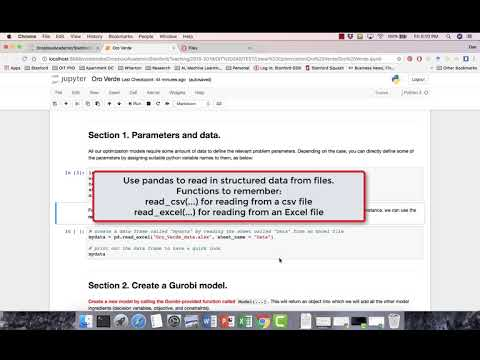

In [5]:
# import video about parameters & data
YouTubeVideo(id='PPOgF7UjMpU',width=600,height=300)

All our optimization models require some amount of data to define the relevant problem parameters. Depending on the case, you can directly define some of the parameters by assigning suitable python variable names to them, as below:

In [6]:
land_avail = 150000              # available land area (in square feet)
water_avail = 50000              # available water (in gallons)
horizon = 10              # start time for commitment (in years) 
annual_seq_commit = 1800              # annual sequestration commitment
min_elms = 15   # minimum requirement on elm trees

For larger and more structured data, we will use the _pandas_ module to create suitable data frames by reading in csv or xlsx files. For instance, we can use the __read.excel(...)__ _pandas_ function to read a particular sheet from an Excel file. 

**For Colab**, we first download the datafile (a CSV file) from Github, and then open it and read the content.

In [7]:
#@markdown - download the data as a CSV file (stored online)
import urllib
url_Q1 = "https://raw.githubusercontent.com/dan-a-iancu/airm/master/Oro_Verde/Oro_Verde_data.csv"
local_file_Q1 = "Oro_Verde_data.csv"   # name of local file where you want to store the downloaded file
aux = urllib.request.urlretrieve(url_Q1, local_file_Q1)    # download from website and save it locally

#@markdown - read data into a pandas dataframe
mydata = pd.read_csv("Oro_Verde_data.csv") 

display(mydata)
print('Successfully read the data.')

,TreeType,SequestrationRate,WaterRequirement,Width,SurvivalRate,SeedlingCost,SeedlingsAvailable
0,Maple,4.3,76.0,130.0,0.7,5.4,1000.0
1,Elm,3.7,48.0,3600.0,0.6,3.2,500.0
2,Spruce,2.8,34.0,400.0,0.8,4.5,1500.0


Successfully read the data.


______
<a id="create_model"></a>
# Section 2. Create a Gurobi model.

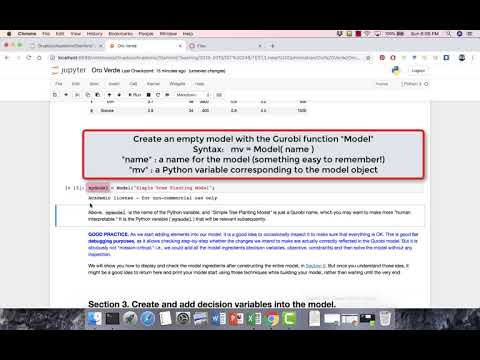

In [8]:
# import video about parameters & data
YouTubeVideo(id='kp3dsKYGboI',width=600,height=300)

The first step in building our optimization model in Gurobi is to create a Gurobi object that will literally serve as a "placeholder" for all our model ingredients (decision variables, objective, and constraints). <font color=red>__To create a new model, we use the function called ``Model(...)`` found in the Gurobi module.__
</font> 

In [9]:
mymodel = Model("Simple Tree Planting Model")

Restricted license - for non-production use only - expires 2022-01-13


Above, ``mymodel`` is the name of the Python variable, and "Simple Tree Planting Model" is just a Gurobi name, which you may want to make more "human interpretable." It is the Python variable (``mymodel``) that will be relevant subsequently.

<font color=blue> __GOOD PRACTICE.__ As we start adding elements into our model, it is a good idea to occasionally inspect it to make sure that everything is OK. This is good __for debugging purposes__, as it allows checking step-by-step whether the changes we intend to make are actually correctly reflected in the Gurobi model. But it is obviously not "mission-critical," i.e., we could add all the model ingredients (decision variables, objective, constraints) and then solve the model without any inspection. </font> <br>

We will show you how to display and check the model ingredients after constructing the entire model, in [Section 6](#inspecting_model). But once you understand those ideas, it might be good to return here and start using those techniques throughout the entire model-building process, rather than waiting until the very end.

_____
<a id="decisions"></a>
# Section 3. Create and add decision variables into the model.

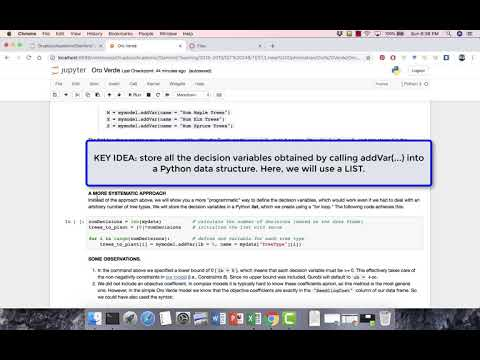

In [10]:
# import video
YouTubeVideo(id='ikn5vac0RnQ',width=600,height=300)

Having constructed an empty Gurobi model, next step is to define and add the decision variables. <br> 
<font color=red>__Adding one decision variable in a Gurobi model is done by calling the ``addVar``(...) method of the model.__ </font> Its syntax is: 

> ``DecisionVariable = Model.addVar ( lb=0.0, ub=GRB.INFINITY, obj=0.0, vtype=GRB.CONTINUOUS, name="" )``

This function does two things:
 1. It returns an object (``DecisionVariable``) that corresponds to the newly created decision variable
 2. It formally adds this decision variable in our Gurobi model
 
All the arguments for the function are optional, and their default values are included above. They have the following meaning:
 - __lb__ : a lower bound on the value of the decision; the default value is 0, so <font color=red>by omitting a lower bound, Gurobi will automatically add a lower bound of 0, which means it will assume our decision is non-negative</font>
 - __ub__ : an upper bound on the value of the decision; the default value is __GRB.INFINITY__, which means $+\infty$ in Gurobi <br>
 - __obj__ : the objective coefficient for the decision variable, i.e., the number that multiplies this decision in the objective
 - __vtype__ : the types of values that the decision can take; we will use __GRB.CONTINUOUS__ for decisions that can take any continuous values, __GRB.INTEGER__ for integers, and __GRB.BINARY__ for decisions that can only take values 0 and 1
 - __name__ : an internal Gurobi name; try to pick something that is meaningful and easy to remember.

<font color=red> __Specifying lower or upper bounds when defining decision variables is equivalent to adding constraints on the decisions.__</font><br> For instance, `` X = mymodel.addVar( lb=5.0, ub=10.0)`` would create a new decision variable ``X`` constrained to satisfy:  5.0 <= ``X`` <= 10.0.

The ``addVar`` method admits some other arguments, but the syntax above is the most common way in which we will be using it. If you are curious or want more details, you can refer to [the extra resources](https://canvas.stanford.edu/courses/90540/modules/items/372795)  on the course Canvas site or to the [Gurobi reference manual](http://www.gurobi.com/documentation/8.0/refman/cpp_grbmodel_addvar.html).

___
__APPLYING THIS IN THE Oro Verde PROBLEM__<br>
In Oro Verde, there are three decision variables: __M__, __E__ and __S__, denoting how many Maple/Elm/Spruce trees to plant, respectively.
To create and add these 3 decision variables in our model, we __could__ use the following code:
> ``M = mymodel.addVar(name = "Num Maple Trees")``<br>
> ``E = mymodel.addVar(name = "Num Elm Trees")``<br>
> ``S = mymodel.addVar(name = "Num Spruce Trees")``<br>

The first line above creates a new decision variable within the Gurobi model ``mymodel``, gives it a name ``"Num Maple Trees"``, and also stores it in the Python variable ``M`` for each access. This decision variable is also given an internal Gurobi name "Num Maple Trees". The next two lines do the same purpose for the Elm and Spruce decision variables. 

Once this code is executed, we could simply use the Python variables ``M, E, S`` whenever we want to refer to the decision variables. The code is acceptable and would achieve what we want in the Oro Verde case. However, this approach would not scale well at all! For instance, imagine we had 1,000 types of trees to pick from -- we would then have to write 1,000 lines of code, which would not only be tedious, but also very error prone!

__A MORE SYSTEMATIC APPROACH__<br>
Instead of the approach above, we will show you a more "programmatic" way to define the decision variables, which would work even if we had to deal with an arbitrary number of tree types. We will store the decision variables in a Python __list__, which we create using a "for loop." The following code achieves this: 

In [11]:
numDecisions = len(mydata)           # calculate the number of decisions (based on the data frame)
trees_to_plant = [0]*numDecisions    # initialize the list with zeros

for i in range(numDecisions):        # define one variable for each tree type
    trees_to_plant[i] = mymodel.addVar(lb = 0, name = mydata["TreeType"][i])

__SOME OBSERVATIONS.__ 

 1. In the command above we specified a lower bound of 0 (``lb = 0``), which means that each decision variable must be >= 0. This effectively takes care of the non-negativity constraints in [our model](#basic_model) (i.e., Constraints 8).  Since no upper bound was included, Gurobi will default to ``ub =`` $+\infty$.<br>

 2. We did not include an objective coefficient. In complex models it is typically hard to know these coefficients apriori, so this method is the most general one. However, in the simple Oro Verde model we know that the objective coefficients are exactly in the ``"SeedlingCost"`` column of our data frame. So we could have also used the syntax:
 > ``trees_to_plant[i] = mymodel.addVar(lb=0, name=mydata["TreeType"][i], obj=mydata["SeedlingCost"][i]) ``

 3. Our choice of Gurobi names above was based on ``mydata["TreeType"]``. This means that our decisions will be called _"Maple,"_ _"Elm"_ and _"Spruce"_ in Gurobi, instead of __M__, __E__ and __S__ as in our [model formulation](#basic_model). (If you want to have identical names, try changing the name in the syntax above to: ``name = mydata["TreeType"][i][0]`` )
 
 4. When formulating your model subsequently, you can gain access to the decision variables in several ways. The preferred method is to use our Python list __trees_to_plant__ created above. Alternatively, we could obtain each variable from the Gurobi model with the __getVarByName(...)__ method. For instance, the decision variable for Maple trees can be obtained either as ``trees_to_plant[0]`` or as ``mymodel.getVarByName("Maple")``.
 
 5. Although we used a python list, you could also use other data structures to store your decisions. For instance, a python __dictionary__ could also work. And sometimes it may even be advantageous to organize your decisions in a matrix instead of a list. We will see other examples throughout the course, but a list is good enough for now.

<font color=red>**IMPORTANT NOTE.**</font> There is an even more concise way to add **several decision variables** at once. This is based on the [``addVars``](https://www.gurobi.com/documentation/9.1/refman/py_model_addvars.html) method, and it has the following syntax:
>   addVars ( *indices, lb=0.0, ub=float('inf'), obj=0.0, vtype=GRB.CONTINUOUS, name="" )

This function returns a dictionary of decision variables, whose keys are derived from the ``*indices`` argument. The most common way to use this is to create one decision for each element of a list. For instance, in the specific example here, we could have added three decisions, for every tree type, by simply using the command:
>    trees_to_plant = mymodel.addVars(["Maple", "Elm", "Spruce"])

This woould have added a decision for each tree name, and we would have gained access to the decisions using these names. For instance, ``trees_to_plant["Maple"]`` would ahve given us direct access to the decision variable for Maple trees. We will be using this type of syntax often for more complex models, but the rest of the tutorial will rely on the simpler form above.

____________
<a id="objective"></a>
# Section 4. Formulate and add the objective to the model.

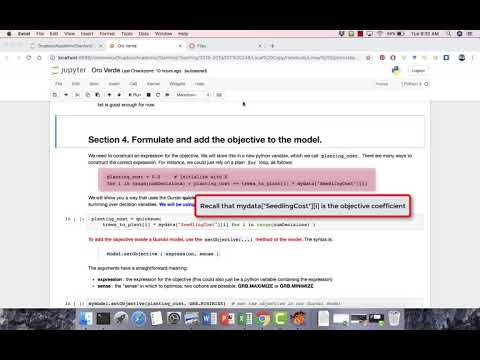

In [12]:
# import video
YouTubeVideo(id='ixCPvnGo8jw',width=600,height=300)

We need to construct an expression for the objective. We will store this in a new python variable, which we call ``planting_cost``. There are many ways to construct the correct expression. For instance, we could just rely on a plain ``for`` loop, as follows:

> ``planting_cost = 0.0     # initialize with 0 `` <br>
> ``for i in range(numDecisions) : planting_cost += trees_to_plant[i] * mydata["SeedlingCost"][i] ``

We will show you a way that uses the Gurobi __quicksum(...)__ function, which is very similar to python's traditional __sum(...)__ function but is more efficient when summing over decision variables. <font color=blue>__We will be using this quite often in formulating models, so make sure you understand how it works!__</font>

In [13]:
 planting_cost = quicksum( 
     trees_to_plant[i] * mydata["SeedlingCost"][i] for i in range(numDecisions) )

<font color=red>**To add the objective inside a Gurobi model, use the ``setObjective(...)`` method of the model.**
</font> The syntax is:

> ``Model.setObjective ( expression, sense )``

The arguments have a straightforward meaning:
 - __expression__ : the expression for the objective (this could also just be a python variable containing the expression)
 - __sense__ : the "sense" in which to optimize; two options are possible, __GRB.MAXIMIZE__ or __GRB.MINIMIZE__

In [14]:
mymodel.setObjective(planting_cost, GRB.MINIMIZE)  # set the objective in our Gurobi model

________
<a id="constraints"></a>
# Section 5. Formulate and add the constraints.

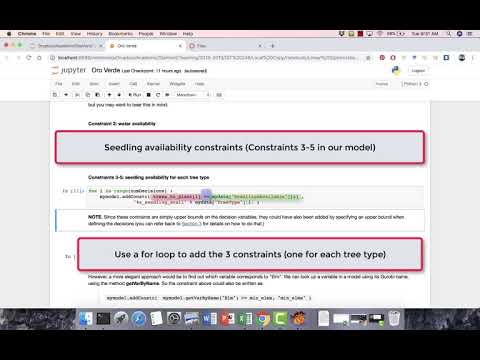

In [15]:
# import video
YouTubeVideo(id='Uj3XSEMi214',width=600,height=300)

We must add several types of constraints. We add these one at a time for clarity. 
<font color=red>
__To add one constraint, use the __addConstr(...)__ method of the model.__
</font> The typical syntax can take two forms:
> ``Model.addConstr ( lhs, sense=None, rhs=None, name="" )`` <br>
> ``Model.addConstr ( expression, name="" )``

The meaning of the arguments is :
 - __lhs__ : the left-hand-side of the constraint
 - __sense__ : the type of the constraint (">=" or "=" or "<=")
 - __rhs__ : the right-hand-side of the constraint
 - __expression__ : a full expression of the constraint that includes the left-hand-side, the sense, and the right-hand-side
 - __name__ : a Gurobi name for the constraint

The first syntax above is a more detailed one, where we can specify separately each ingredient of the constraint. The second syntax is more compact, and we will be using it more frequently. But these two are equivalent in the sense that every correct specification of a constraint must include all three elements: left-hand-side, sense, and right-hand-side. For more details, please refer to the [extra resources on Canvas](https://canvas.stanford.edu/courses/90540/modules/items/372795) or the [Gurobi manual](http://www.gurobi.com/documentation/8.0/refman/py_model_addconstr.html).

<font color=blue>
__GOOD PRACTICE__. While there are many ways to express the same constraint logic,  we recommend adding constraints so that __the right-hand-side is a problem parameter / data__. This gives each constraint a more clear physical interpretation, and will be helpful later when we discuss sensitivity analysis.
</font>

#### Constraint 1: land availability

In [16]:
mymodel.addConstr( 
    quicksum( trees_to_plant[i] * mydata["Width"][i] for i in range(numDecisions)) <= land_avail , 
    "land_avail")

<gurobi.Constr *Awaiting Model Update*>

Note that Gurobi reports that your model is "awaiting update." This is related to Gurobi's "lazy updating" feature. Gurobi will actually not process any changes in the model until we actually tell it to do so through some explicit commands. We will revisit this issue in [the next section](#inspecting_model)  once all the constraints are added, but you may want to bear this in mind.

#### Constraint 2: water availability

In [17]:
mymodel.addConstr( 
    quicksum( trees_to_plant[i] * mydata["WaterRequirement"][i] for i in range(numDecisions)) <= water_avail , 
    "water_avail")

<gurobi.Constr *Awaiting Model Update*>

#### Constraints 3-5: seedling availability for each tree type

In [18]:
for i in range(numDecisions) :
    mymodel.addConstr( trees_to_plant[i] <= mydata["SeedlingsAvailable"][i] , 
                "%s_seedling_avail" % mydata["TreeType"][i] )

__NOTE.__ Since these contraints are simply upper bounds on the decision variables, they could have also been added by specifying an upper bound when defining the decisions (you can refer back to [Section 3](#decisions) for details on how to do that.)

#### Constraint 6: minimum number of elm trees

In [19]:
# we know that the decision variable for Elm is  "trees_to_plant[1]", so we could just write:
mymodel.addConstr(  trees_to_plant[1] >= min_elms, "min_elms" )

<gurobi.Constr *Awaiting Model Update*>

However, a more elegant approach would be to find out which variable corresponds to "Elm". We can look up a variable in a model using its Gurobi name, using the method __getVarByName__. So the constraint above could also be written as:

> ``mymodel.addConstr(  mymodel.getVarByName("Elm") >= min_elms, "min_elms" )``

#### Constraint 7: minimum carbon sequestration commitment

In [20]:
mymodel.addConstr( 
    quicksum( trees_to_plant[i] * mydata["SurvivalRate"][i] * mydata["SequestrationRate"][i]  
    for i in range(numDecisions) ) >= annual_seq_commit , "carbon_seq")

<gurobi.Constr *Awaiting Model Update*>

<a id="inspecting_model"></a>
# Section 6. Inspecting the model.

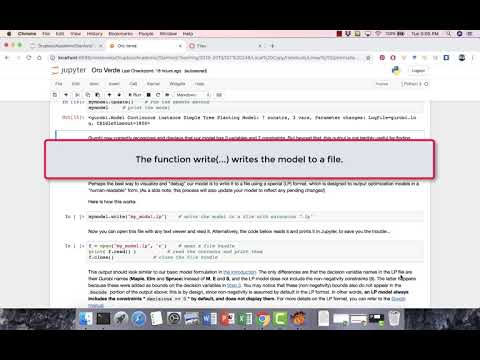

In [21]:
# import video
YouTubeVideo(id='f3kIZgpuKGU',width=600,height=300)

<font color=blue> __GOOD PRACTICE.__ Now that we have added all the ingredients, __it is quite critical to check the model and make sure it is actually correct.__</font> 

One way to do this is simply to __print the model__. Here is the output we would get by printing right now:

In [22]:
mymodel

<gurobi.Model Continuous instance Simple Tree Planting Model: 0 constrs, 0 vars, No parameter changes>

This might seem like a mistake: the model still looks "empty," although we just added everything! But this is __not__ an error. It is related to Gurobi's 'lazy updating' feature, which means that Gurobi will not process any updates to the model until we run some specific commands that force it to do that. There are three methods that do this, and we will talk about each subsequently. These are:
 - the __update()__ method : as the name says, this simply updates the model
 - the __write(...)__ method : this writes the model to a file
 - the __optimize()__ method : this solves the model

<a id="model_update"></a>
### Updating the model to reflect all the changes

To update a Gurobi model so it reflects all the changes made (with no additional action), run the __update()__ method.

In [23]:
mymodel.update()    # run the update method
mymodel     # print the model

<gurobi.Model Continuous instance Simple Tree Planting Model: 7 constrs, 3 vars, No parameter changes>

Gurobi now correctly recognizes and displays that our model has 3 variables and 7 constraints. But beyond that, this output is not terribly useful for finding __errors__ in the model...

<a id="write_model"></a>
### Writing the model to a file for inspection

Perhaps the best way to visualize and "debug" our model is to write it to a file using a special (LP) format, which is designed to output optimization models in a "human-readable" form. (As a side note, this process will also update your model to reflect any pending changes!)

Here is how this works.

In [24]:
mymodel.write("my_model.lp")    # write the model to a file with extension ".lp"

Now you can open this file with any text viewer and read it. Alternatively, the code below reads it and prints it in Jupyter, to save you the trouble...

In [25]:
f = open("my_model.lp", 'r')    # open a file handle
print( f.read() )           # read the contents and print them
f.close()              # close the file handle

\ Model Simple Tree Planting Model
\ LP format - for model browsing. Use MPS format to capture full model detail.
Minimize
  5.4 Maple + 3.2 Elm + 4.5 Spruce
Subject To
 land_avail: 130 Maple + 3600 Elm + 400 Spruce <= 150000
 water_avail: 76 Maple + 48 Elm + 34 Spruce <= 50000
 Maple_seedling_avail: Maple <= 1000
 Elm_seedling_avail: Elm <= 500
 Spruce_seedling_avail: Spruce <= 1500
 min_elms: Elm >= 15
 carbon_seq: 3.01 Maple + 2.22 Elm + 2.24 Spruce >= 1800
Bounds
End



This output should look similar to our basic model formulation in [the introduction](#basic_model). The only differences are that the decision variable names in the LP file are their Gurobi names (__Maple__, __Elm__ and __Spruce__) instead of __M__, __E__ and __S__, and the LP model does not include the non-negativity constraints (8). The latter happens because these were added as bounds on the decision variables in [Step 3](#decisions). You may notice that these (non-negativity) bounds also do not appear in the ``Bounds`` portion of the output above; this is by design, since non-negativity is assumed by default in the LP format. In other words, __an LP model always includes the constraints "__``decisions >= 0``__" by default, and does not display them__. For more details on the LP format, you can refer to the [Gurobi manual](https://www.gurobi.com/documentation/8.0/refman/lp_format.html).

<font color=blue> __GOOD PRACTICE.__ If we detect a mistake when inspecting the model, the cleanest way to proceed would be to restart the entire notebook, by clicking the __Kernel__ button in Jupyter and selecting  __Restart__. This allows revisiting each step of the process to identify and fix the mistake(s). This is also why __it is very helpful to print out the model at intermediate steps__, so that we do not wait until the very end to identify potential issues! </font>

As a side note, in very large models like the ones used in practice, it may be too costly to rerun the entire notebook/process. Gurobi has functionality that allows changing a model by removing constraints or decision variables. We do not advocate using this as a procedure to fix mistakes (because your notebook would essentially always first _make_ mistakes and then _fix_ them !), but if you are curious to learn more about these functions you can refer to the [extra resources on the Canvas site](https://canvas.stanford.edu/courses/90540/modules/items/372795) or to the Gurobi manual.

____
<a id="solve"></a>
# Section 7. Solve/optimize the model.

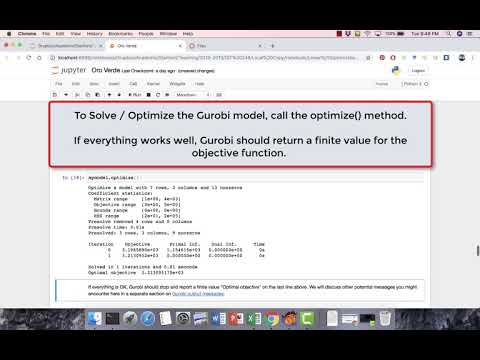

In [26]:
# import video
YouTubeVideo(id='KS-vJaTCkJI',width=600,height=300)

<font color=red>**To solve/optimize our Gurobi model, we use the ``optimize()`` method of the model object.**</font><br>  (__Note:__ This function also updates your model to reflect any pending changes.)

In [27]:
mymodel.optimize()

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (linux64)
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads
Optimize a model with 7 rows, 3 columns and 13 nonzeros
Model fingerprint: 0x017ecc2f
Coefficient statistics:
  Matrix range     [1e+00, 4e+03]
  Objective range  [3e+00, 5e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 2e+05]
Presolve removed 4 rows and 0 columns
Presolve time: 0.02s
Presolved: 3 rows, 3 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.1965890e+03   1.154615e+03   0.000000e+00      0s
       1    3.2130952e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.02 seconds
Optimal objective  3.213095170e+03


If everything is OK, Gurobi should stop and report a finite value "Optimal objective" on the last line above. We will discuss other potential messages you might encounter here in a separate section on [Gurobi output messages](#Gurobi_messages).

____
<a id="printing"></a>
# Section 8. Extract the optimized results.

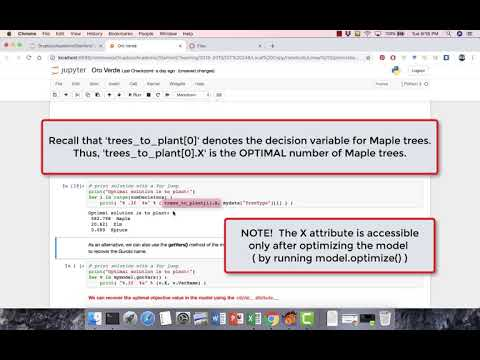

In [28]:
# import video
YouTubeVideo(id='TUuMcjdrMsM',width=600,height=300)

Once Gurobi has finished optimizing the model, we will likely want to extract some information concerning the solution and its properties. (__NOTE.__ The functions in this section can only be run __after__ Gurobi is done.) 

<font color=red> __We can recover the optimal value of a decision variable using its .X attribute.__</font><br>
We print the optimal solution here with a _for loop_, but depending on the (size of your) model, you may want to do this differently. 

In [29]:
# print solution with a for loop
print("Optimal solution is to plant:")
for i in range(numDecisions) :
    print( "% .3f  %s" % ( trees_to_plant[i].X, mydata["TreeType"][i] ) )

Optimal solution is to plant:
 582.798  Maple
 20.621  Elm
 0.000  Spruce


As an alternative, we can also use the __getVars()__ method of the model to obtain the variables and print them out. Note that the __VarName__ attribute can be used to recover the Gurobi name.

In [30]:
# print solution with a for loop
print("Optimal solution is to plant:")
for v in mymodel.getVars() :
    print( "%.3f  %s" % (v.X, v.VarName) )

Optimal solution is to plant:
582.798  Maple
20.621  Elm
0.000  Spruce


<font color=red> __We can recover the optimal objective value in the model using the `.objVal` attribute.__ </font>

In [31]:
# print the value of the objective
print("Optimal cost is: %.3f"  % mymodel.objVal)

Optimal cost is: 3213.095


____
<a id="evaluating_constraints"></a>
# Section 9. Extract information concerning the constraints.

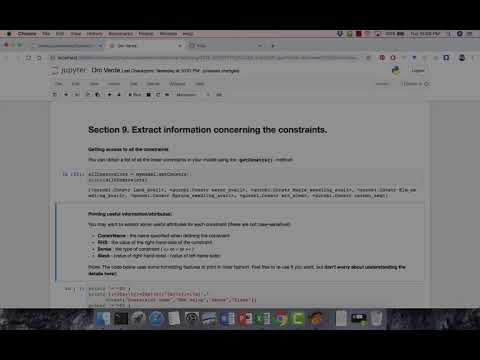

In [32]:
# import video
YouTubeVideo(id='qD6PPl1-Mg8',width=600,height=300)

#### Getting access to all the constraints
You can obtain a list of all the linear constraints in your model using the __``getConstrs()``__ method:

In [33]:
allConstraints = mymodel.getConstrs()
print(allConstraints)

[<gurobi.Constr land_avail>, <gurobi.Constr water_avail>, <gurobi.Constr Maple_seedling_avail>, <gurobi.Constr Elm_seedling_avail>, <gurobi.Constr Spruce_seedling_avail>, <gurobi.Constr min_elms>, <gurobi.Constr carbon_seq>]


#### Printing useful information/attributes:
You may want to extract some useful attributes for each constraint (these are not case-sensitive!):
 - __ConstrName__  : the name specified when defining the constraint
 - __RHS__    : the value of the right-hand-side of the constraint
 - __Sense__ : the type of constraint ( <= or = or >= ) 
 - __Slack__  : (value of right-hand-side) - (value of left-hand-side)
 
(Note: The code below uses some formatting features to print in nicer fashion. Feel free to re-use it you want, but __don't worry about understanding the details here__!)

In [34]:
print( '='*90 )
print('{:<35s}\t{:<20s}\t{:^10s}\t{:<17s}'.\
      format("Constraint name","RHS value","Sense","Slack"))
print( '='*90 )

for c in allConstraints :
    print( '{:<35s}\t{:<20.2f}\t{:^10s}\t{:<17.2f}'.\
          format(c.ConstrName, c.RHS, c.Sense, c.Slack) )

Constraint name                    	RHS value           	  Sense   	Slack            
land_avail                         	150000.00           	    <     	0.00             
water_avail                        	50000.00            	    <     	4717.56          
Maple_seedling_avail               	1000.00             	    <     	417.20           
Elm_seedling_avail                 	500.00              	    <     	479.38           
Spruce_seedling_avail              	1500.00             	    <     	1500.00          
min_elms                           	15.00               	    >     	-5.62            
carbon_seq                         	1800.00             	    >     	0.00             


_____
<a id="Gurobi_messages"></a>
# Section 10. Output messages in Gurobi.

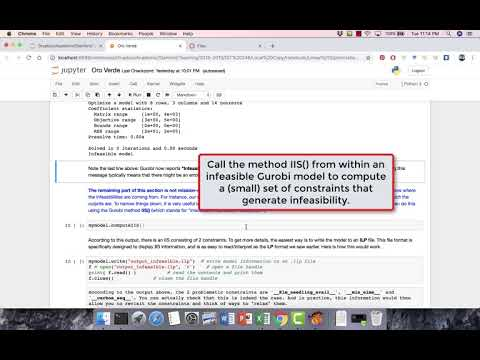

In [35]:
# import video
YouTubeVideo(id='Z7ZGvRaWCag',width=600,height=300)

<a id="solved_optimality"></a>
## Model solved to optimality

Let us first read our fully-functional model from the file where we saved it earlier.

In [36]:
mymodel = read("my_model.lp")    # read our fully-functional model from a file

Read LP format model from file my_model.lp
Reading time = 0.00 seconds
: 7 rows, 3 columns, 13 nonzeros


In [37]:
# Typical message when model is solved to optimality
mymodel.optimize()

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (linux64)
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads
Optimize a model with 7 rows, 3 columns and 13 nonzeros
Model fingerprint: 0x8b66453a
Coefficient statistics:
  Matrix range     [1e+00, 4e+03]
  Objective range  [3e+00, 5e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 2e+05]
Presolve removed 4 rows and 0 columns
Presolve time: 0.01s
Presolved: 3 rows, 3 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.1965890e+03   1.154615e+03   0.000000e+00      0s
       1    3.2130952e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  3.213095170e+03


Note that Gurobi reports finding an "Optimal objective" with a value on the last line. This means the model was correctly solved to optimality.

<a id="infeasible"></a>
## Infeasible model

As it turns out, if we required planting at least 1000 Elms (instead of just 15), the model would become __infeasible__, i.e., it would be impossible to find values for __M__, __E__ and __S__ to satisfy all the constraints. Let us see what happens in Gurobi when this is the case.

In [38]:
mymodel = read("my_model.lp")              # read our fully-functional model
mymodel.addConstr( mymodel.getVarByName("Elm") >= 1000, "tough_constraint" )
mymodel.optimize()    # solve the new model

Read LP format model from file my_model.lp
Reading time = 0.00 seconds
: 7 rows, 3 columns, 13 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (linux64)
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads
Optimize a model with 8 rows, 3 columns and 14 nonzeros
Model fingerprint: 0xbe054034
Coefficient statistics:
  Matrix range     [1e+00, 4e+03]
  Objective range  [3e+00, 5e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 2e+05]
Presolve time: 0.01s

Solved in 0 iterations and 0.01 seconds
Infeasible model


Note the last line above: Gurobi now reports __"Infeasible model."__ Most of the models we solve together in class should be feasible, so encountering this message typically means that there might be an error in defining the decision variables or constraints. 

<font color=blue> __The remaining part of this section is not mission-critical, but is definitely extremely relevant in practice.__ In a real-world model, we may not know where the infeasibilities are coming from. For instance, our model could contain a very large number of constraints, and it may be hard to guess apriori _which_ the culprits are. To narrow things down, it is very useful to isolate a small set of constraints that taken together already make the model infeasible. We can do this using the Gurobi method __IIS()__ (which stands for "irreducible inconsistent subsystem"). </font>

In [39]:
mymodel.computeIIS()


IIS computed: 2 constraints and 0 bounds
IIS runtime: 0.00 seconds


According to this output, there is an IIS consisting of 2 constraints. To get more details, the easiest way is to write the model to an __ILP__ file. This file format is specifically designed to display IIS information, and is as easy to read/interpret as the __LP__ format we saw earlier. Here is how this would work.

In [40]:
mymodel.write("output_infeasible.ilp")  # write model information to an .ilp file
f = open("output_infeasible.ilp", 'r')    # open a file handle
print( f.read() )           # read the contents and print them
f.close()              # close the file handle

\ Model _copy
\ LP format - for model browsing. Use MPS format to capture full model detail.
Minimize
 
Subject To
 Elm_seedling_avail: Elm <= 500
 tough_constraint: Elm >= 1000
Bounds
 Elm free
End



According to the output above, the 2 problematic constraints are '__Elm_seedling_avail__' and '__min_elms__' In practice, this information would then allow you to revisit the constraints and think of ways to "relax" them.

<a id="unbounded"></a>
## Unbounded model

In [41]:
mymodel = read("my_model.lp")    # read our fully-functional model

# remove the carbon sequestration requirement
mymodel.remove(mymodel.getConstrByName("carbon_seq"))

# allow the Maple decision to take negative values: we do this by changing the lower bound from 0 to -$\infty$
mymodel.getVarByName("Maple").setAttr("LB", -GRB.INFINITY)

mymodel.optimize()    # solve the new model

Read LP format model from file my_model.lp
Reading time = 0.01 seconds
: 7 rows, 3 columns, 13 nonzeros
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (linux64)
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads
Optimize a model with 6 rows, 3 columns and 10 nonzeros
Model fingerprint: 0x960b6889
Coefficient statistics:
  Matrix range     [1e+00, 4e+03]
  Objective range  [3e+00, 5e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 2e+05]
Presolve time: 0.01s

Solved in 0 iterations and 0.01 seconds
Infeasible or unbounded model


The last line identifies the model as being "Infeasible or unbounded." This usually corresponds to unbounded models, as for infeasible models Gurobi generally produces the more precise message that we saw earlier. Real-world models should almost always be bounded, so if you ever encouter this it likely means that you forgot to include all the relevant constraints in the problem.

_____
<a id="change_model"></a>
# Section 11. Sensivity Analysis and Shadow Prices.

The parameters / data in a problem are almost always imprecise, e.g., they are often estimated through some statistical procedure. It is therefore critical to understand how the results of the optimization would change when the data changes. This is known as __sensitivity analysis__, and is a critical step in understanding the model outputs and generating credible recommendations. Here, we will discuss briefly how to conduct sensitivity analysis in an efficient way. 

To illustrate these concepts, consider the following motivating question: <font color=blue>_Suppose that the land available is not 150,000 square feet with certainty. We would like to know how Oro Verde's optimal costs would change when land availability can vary between 140,000 and 160,000 square feet._</font>

__Step 1.__ We start by creating a list of all the values that we want to test. We could manually construct a list with these values, but it is easier to rely on a python function called `arange` found in the `numpy` package. You can read more about it in [this documentation page](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.arange.html). Briefly, its syntax is :
 > `arange(init_value, final_value, step)`

where `init_value, final_value` and `step` can all be float values, i.e., they do not have to be integers. This returns the list of all values between `init_value` and `final_value` in increments of size `step`. __(Similar to `range`, this list includes `init_value` but excludes `final_value`.)__ 

In [42]:
from numpy import arange   # import the function `arange` from the numpy package

LandAvailableVals = list(arange(140000,160001,2000))  # we use 160001 instead of 160000 so as to include the latter
print(LandAvailableVals)

[140000, 142000, 144000, 146000, 148000, 150000, 152000, 154000, 156000, 158000, 160000]


__Step 2.__ We need to obtain a handle on the constraint that we want to change. There are many ways to do that. For instance, we could have stored the constraint when we initially defined it (under In[11] above), by using a syntax of the form:
> `c = mymodel.addConstr(...)`

This would add the constraint to the model and also store it in the variable `c`, and works exactly in the same way as the `addVar` syntax. (If we wanted to store several constraints, we could simply use a python list or a dictionary.)

Here, we use the method `getConstrByName` from our model object, which allows recovering a constraint using its name.

In [43]:
mymodel = read("my_model.lp")    # read our fully-functional model

c = mymodel.getConstrByName("land_avail")  # store the relevant constraint in a variable `c`

Read LP format model from file my_model.lp
Reading time = 0.00 seconds
: 7 rows, 3 columns, 13 nonzeros


__Step 3.__ Within a `for` loop, change the constraint right-hand-side using the `setAttr` method, resolve the model, and store the objective.

In [44]:
allCostValues = [0]*len(LandAvailableVals)   # a list where we will store the values of the objective

# loop over all the values to test
for i in range(len(LandAvailableVals)):
    
    c.setAttr('rhs',LandAvailableVals[i])  # change the RHS for the constraint
    
    #mymodel.write("model_" + str(i) + ".lp")  # write model information to an .lp file
   # f = open("model_" + str(i) + ".lp", 'r')    # open a file handle
   # print( f.read() )           # read the contents and print them
   # f.close()              # close the file handle
    
    mymodel.optimize()    # resolve the model
    
    allCostValues[i] = mymodel.objVal  # store the objective

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (linux64)
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads
Optimize a model with 7 rows, 3 columns and 13 nonzeros
Model fingerprint: 0xa6a0ae34
Coefficient statistics:
  Matrix range     [1e+00, 4e+03]
  Objective range  [3e+00, 5e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 1e+05]
Presolve removed 4 rows and 0 columns
Presolve time: 0.01s
Presolved: 3 rows, 3 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.1987654e+03   1.158624e+03   0.000000e+00      0s
       1    3.2153289e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  3.215328896e+03
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (linux64)
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads
Optimize a model with 7 rows, 3 columns and 13 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 4e+03]
  Obj

__Step 4.__ To visualize the dependency, it is useful to do a plot. We use the function `pyplot` from `matploblib`, which we import below. (See the tutorial for Class 2 for more details!)

In [45]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Total costs for Oro Verde')

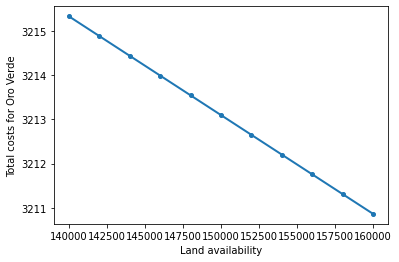

In [46]:
plt.plot(LandAvailableVals, allCostValues, marker='o', linestyle='solid', linewidth=2, markersize=4)
plt.xlabel("Land availability")
plt.ylabel("Total costs for Oro Verde")

Note that the dependency is actually __linear__! This is always the case in linear optimization problems when parameter changes occur in a limited range. (If we examined a wider range for land availability values, the slope of the dependency may change! We will see more examples of this in class). 

We can actually calculate the slope of the line above:

In [47]:
print("The slope above is: %.5f" % ((allCostValues[6]-allCostValues[5])/(LandAvailableVals[6]-LandAvailableVals[5])) )

The slope above is: -0.00022


This slope actually bears a name in optimization: __shadow price__. More formally, __the shadow price of a constraint__ is the rate of change (i.e., slope) in the dependency of the optimal objective function on the right-hand-side of the constraint. 

The shadow price is extremely useful beyond sensitivity analysis: it can be used to "price" important resources. For instance, in the example above, 10,000 extra square feet of land would change Oro Verde's costs by roughly $-0.00022 \cdot 10,000 = -\$2.2$. This means that Oro Verde should be willing to pay at most \$2.2 to obtain access to the extra land.

Modern optimization solvers directly calculate these shadow prices. For instance, in Gurobi you can obtain them from the `.Pi` attribute of a constraint, which is available after solving a model.

In [48]:
print("The shadow price of the `Land Availability Constraint` is: %.5f" % c.Pi)

The shadow price of the `Land Availability Constraint` is: -0.00022


__NOTE.__ The shadow price above was actually obtained from the very last run of our model in the `for` loop in In[32], so it actually corresponds to the slope at the point $x=160,000$. Since the dependency is linear here in the entire range of interest, this is also the slope at $x=150,000$. More broadly, if we wanted the shadow price at a particular value $x$, then we need to solve the model with a value of the RHS = $x$, and then look at that value of `c.Pi`.